# Import

In [13]:
seed = 42

#from sklearnex import patch_sklearn
#patch_sklearn()

# Import libraries
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(seed)
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import (accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, 
                             recall_score, confusion_matrix, precision_recall_curve, auc, 
                             average_precision_score)
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectPercentile, f_classif, f_regression, SelectFromModel
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
import statistics
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score

import pickle

# Caricamento Dati

In [14]:

file_path = "../CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()
labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )


Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]


## Encoders

In [3]:
import zipfile
import pandas as pd
import numpy as np

# Percorso del file .npy
# Percorso del file .npy
file_path = "../indici_aree/aree_07.npy"
arraytuple = np.load(file_path)

# Converti il primo elemento di ogni tupla in int
arraytuple = [(int(t[0]), t[1], t[2]) for t in arraytuple]

### 1C 
#zip_file_path = "../CSV/2_5/GMP/EncodersImagenetFullImage/VGG_ALL_SLICES_Imagenet_FullImage.zip"
zip_file_path = "../CSV/2_5/GMP/EncodersImagenetFullImage/RESNET_ALL_SLICES_Imagenet_FullImage.zip"
#zip_file_path = "../CSV/2_5/GMP/EncodersImagenetFullImage/INCEPTION_ALL_SLICES_Imagenet_FullImage.zip"

### 2B
#zip_file_path = "../CSV/2_5/GMP/EncodersNuoviPesiRitagliata/INCEPTION_ALL_SLICES_NuoviPesi_Ritagliata.zip"

###  1B
#zip_file_path = "../CSV/2_5/GMP/EncodersImagenetRitagliata/VGG_ALL_SLICES_Imagenet_Ritagliata.zip"
#zip_file_path = "../CSV/2_5/GMP/EncodersImagenetRitagliata/RESNET_ALL_SLICES_Imagenet_Ritagliata.zip"
#zip_file_path = "../CSV/2_5/GMP/EncodersImagenetRitagliata/INCEPTION_ALL_SLICES_Imagenet_Ritagliata.zip"

### 2C
#zip_file_path = "../CSV/2_5/GMP/EncodersNuoviPesiFullImage/INCRES_ALL_SLICES_NuoviPesi_FullImage.zip"

# Apri il file zip e leggi il CSV direttamente dalla memoria
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Ottieni il nome del file CSV dentro lo zip
    csv_filename = zip_ref.namelist()[0]
    # Leggi il file CSV direttamente dalla memoria
    with zip_ref.open(csv_filename) as csv_file:
        data = pd.read_csv(csv_file)

# Ordina i pazienti in ordine crescente
arraytuple_sorted = sorted(arraytuple, key=lambda t: t[0])

# Crea un dizionario con le slice e le loro aree, raggruppate per paziente
patients_slices = {}
for t in arraytuple_sorted:
    patient_id = t[0]
    if patient_id not in patients_slices:
        patients_slices[patient_id] = []
    patients_slices[patient_id].append(t)

# Per ogni paziente, tieni solo le 5 slice con area maggiore
for patient_id in patients_slices:
    patients_slices[patient_id] = sorted(patients_slices[patient_id], key=lambda x: x[2], reverse=True)[:5]

# Ora creiamo una lista finale di tuple per i pazienti ordinati con le 5 slice maggiori
final_tuples = []
for patient_id in sorted(patients_slices):
    final_tuples.extend(patients_slices[patient_id])

# Filtra il DataFrame per mantenere solo le righe che corrispondono agli elementi di final_tuples
filtered_data = data[
    data.apply(lambda row: any((row['Patient'] == (t[0]) and row['Slice'] == t[1]) for t in final_tuples), axis=1)
]

# Percorso del secondo file zip contenente il secondo CSV
second_zip_file_path = "../CSV/GMP/EncodersAllSlices/Radiomica_Wavelet_25D.csv.zip"

# Apri il secondo file zip e leggi il CSV direttamente dalla memoria
with zipfile.ZipFile(second_zip_file_path, 'r') as zip_ref:
    # Ottieni il nome del file CSV dentro lo zip
    second_csv_filename = zip_ref.namelist()[0]
    # Leggi il file CSV direttamente dalla memoria
    with zip_ref.open(second_csv_filename) as second_csv_file:
        second_csv = pd.read_csv(second_csv_file)

# Controlla che gli indici delle slice di ogni paziente siano presenti nel secondo CSV
for patient_id in patients_slices:
    slices_in_first = [t[1] for t in patients_slices[patient_id]]
    slices_in_second = second_csv[second_csv['Paziente'] == patient_id]['Slice'].tolist()
    
    # Se uno degli indici di slice non è presente nel secondo CSV, stampa un errore
    if not set(slices_in_first).issubset(set(slices_in_second)):
        print(f"Errore: alcune slice del paziente {patient_id} non sono presenti nel secondo CSV.")
        exit()

# Creazione delle ultime variabili se il controllo è ok
filtered_patients = []

for patient_id in sorted(patients_slices):
    # Filtra i dati per il paziente specifico
    filtered_patient_data = filtered_data[filtered_data['Patient'] == patient_id]
    
    # Dopo aver filtrato per paziente, rimuovi le prime due colonne ('Patient' e 'Slice')
    filtered_patient_data = filtered_patient_data.drop(filtered_patient_data.columns[:2], axis=1)
    
    slices = []
    
    for _, slice_row in filtered_patient_data.iterrows():
        # Seleziona solo le colonne filtrate per ogni slice
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    
    filtered_patients.append(slices)

# Stampa per verificare che le prime due colonne siano state rimosse
print(filtered_patient_data.head())


      Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
2812   7.748806   8.050818   1.336299        0.0   0.105148  15.058784   
2813   8.453594   6.988800   1.369058        0.0   0.187635  14.992767   
2814   8.851427   7.143260   1.272021        0.0   0.368279  14.835576   
2815   8.811873   6.306379   1.088626        0.0   0.303820  14.816749   
2816   9.455294   7.047685   0.959360        0.0   0.377472  14.868426   

      Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_2038  \
2812  12.399562  10.369722   0.000000  16.843360  ...     15.415403   
2813  11.861170   9.955970   0.005902  16.676262  ...     15.382915   
2814  12.128864   9.607331   0.000000  16.091442  ...     15.495625   
2815  10.410156   8.369694   0.000000  15.186122  ...     15.301855   
2816   8.617913   7.509737   0.000000  15.101886  ...     15.365046   

      Feature_2039  Feature_2040  Feature_2041  Feature_2042  Feature_2043  \
2812      9.280601     17.903206           0.0    

## Radiomica

In [5]:
import zipfile
import pandas as pd
import numpy as np

# Percorso del file .npy
file_path = "../indici_aree/aree_07.npy"
arraytuple = np.load(file_path)

# Converti il primo elemento di ogni tupla in int
arraytuple = [(int(t[0]), t[1], t[2]) for t in arraytuple]

# Percorso del file zip contenente il CSV
zip_file_path = "../CSV/GMP/EncodersAllSlices/Radiomica_Wavelet_25D.csv.zip"

# Apri il file zip e leggi il CSV direttamente dalla memoria
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    csv_filename = zip_ref.namelist()[0]  # Se c'è un solo file, puoi usare il primo
    with zip_ref.open(csv_filename) as csv_file:
        data = pd.read_csv(csv_file)

# Crea un dizionario con le slice e le loro aree, raggruppate per paziente
patients_slices = {}
for t in arraytuple:
    patient_id = t[0]
    if patient_id not in patients_slices:
        patients_slices[patient_id] = []
    patients_slices[patient_id].append(t)

# Per ogni paziente, tieni solo le 5 slice con area maggiore
for patient_id in patients_slices:
    patients_slices[patient_id] = sorted(patients_slices[patient_id], key=lambda x: x[2], reverse=True)[:5]

# Crea una lista di tuple finali per i pazienti ordinati con le 5 slice maggiori
final_tuples = []
for patient_id in sorted(patients_slices):
    final_tuples.extend(patients_slices[patient_id])

# Filtra il DataFrame per mantenere solo le righe che corrispondono agli elementi di final_tuples
filtered_data = data[
    data.apply(lambda row: any((row['Paziente'] == (t[0]) and row['Slice'] == t[1]) for t in final_tuples), axis=1)
]

# Filtra le colonne che iniziano con 'original' o 'dentro'
filtered_patients = []
for patient_id in loaded_patients:
    # Filtra i dati per il paziente specifico
    filtered_patient_data = filtered_data[filtered_data['Paziente'] == patient_id]
    
    # Rimuovi le prime due colonne ('Paziente' e 'Slice')
    filtered_patient_data = filtered_patient_data.drop(filtered_patient_data.columns[:2], axis=1)
    
    # Rimuovi le colonne che iniziano con "diagnostics"
    filtered_patient_data = filtered_patient_data.filter(regex='^(?!diagnostics).*')

    slices = []
    
    for _, slice_row in filtered_patient_data.iterrows():
        # Seleziona solo le colonne filtrate per ogni slice
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    
    filtered_patients.append(slices)

# Stampa per verificare che le colonne "diagnostics" siano state rimosse
print(filtered_patient_data.head())

      original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
5177                     0.670387                         30.390451   
5178                     0.646481                         31.754581   
5179                     0.606961                         33.766174   
5180                     0.558283                         35.566134   
5181                     0.558702                         36.113805   

      original_shape2D_MaximumDiameter  original_shape2D_MeshSurface  \
5177                         31.064449                         400.0   
5178                         32.249031                         432.0   
5179                         33.615473                         460.0   
5180                         34.985711                         485.0   
5181                         35.846897                         474.5   

      original_shape2D_MinorAxisLength  original_shape2D_Perimeter  \
5177                         20.373362                  117.396970   


# Funzioni

In [15]:
## funzione per creare array da array di array
def continue_array(filtered_patients, labels):
    all_features = []
    for patient in filtered_patients:
        for image_features in patient:
            all_features.append(image_features)

    all_features_array = np.array(all_features)
    expanded_labels = []
    expanded_patient_ids = []

    for i in range(len(filtered_patients)):
        num_images = len(filtered_patients[i])
        expanded_labels.extend([labels[i]] * num_images)
        expanded_patient_ids.extend([loaded_patients[i]] * num_images)

    expanded_labels_array = np.array(expanded_labels)
    expanded_patient_ids_array = np.array(expanded_patient_ids)

    return all_features_array, expanded_labels_array, expanded_patient_ids_array


## funzioni per feature correlation
def filter_highly_correlated_features(df, corr, threshold=0.85):
    columns = np.full((corr.shape[0],), True, dtype=bool)
    removed_features = []

    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= threshold:
                if columns[j]:
                    columns[j] = False
                    removed_features.append(df.columns[j])

    return removed_features


def perform_correlation(z_train, y_train, numero = 32, threshold = 0.85):
    all_images, _, _= continue_array(z_train, y_train)

    df = pd.DataFrame(all_images, columns=[f'feature_{i}' for i in range(numero)])

    corr_matrix = df.corr()

    features_selected = filter_highly_correlated_features(df, corr_matrix, threshold)
    
    return features_selected

## funzione per rimuovere le features con p_value maggiore della treshold
def select_features_by_p_value(x_train_expanded, y_train_expanded, p_value_threshold=0.05):

    p_values = []
    num_features = x_train_expanded.shape[1]

    for i in range(num_features):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)

    p_values = np.array(p_values)

    selected_features_indices = np.where(p_values < p_value_threshold)[0]

    sorted_indices = selected_features_indices[np.argsort(p_values[selected_features_indices])]

    x_train_expanded = x_train_expanded[:, sorted_indices]

    return x_train_expanded, sorted_indices

## funzione per rimozione di features specifiche
def remove_features_from_patients(patients, features_to_remove):
    feature_indices_to_remove = [int(feature.split('_')[1]) for feature in features_to_remove]
    
    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.delete(image_features, feature_indices_to_remove, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))    

    return final_patients


## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=2000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## FEATURE SELECTION P_VALUE
# Seleziona e ordina le feature basate sui p-value con un test t di Student poi 
# ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

def p_value_feature_selection(x_train_expanded, y_train_expanded, num_features):
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna feature
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)


    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)
    sorted_indices = sorted_indices[:num_features]

    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## funzione per lasciare solo le features indicate per array di array
def keep_features_in_patients(patients, features_to_keep):

    feature_indices_to_keep = [int(feature) for feature in features_to_keep]

    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.take(image_features, feature_indices_to_keep, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))

    return final_patients


## funzione per lasciare solo le features indicate per array
def filter_patients_features(filtered_patients, selected_features):
    filtered_patients_selected = []
    
    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected


def classifierinitialization(classifier):
    if classifier == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif classifier == 'Logistic':
                            classi = LogisticRegression(random_state=42, max_iter=2000)
    elif classifier == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif classifier == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
    elif classifier == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation = 'logistic')
    elif classifier == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42, max_iter=2000)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'
                                )
    return classi

## funzione per effettuarr majority voting o mean su tutte le slice di un paziente, per passare da una predizione sulla slice
## alla predizione per il paziente

def prob_to_binary(predictions_proba, patient_scores, threshold, mode):
    final_predictionarray = []          
    
    if mode == 'MV':  # Majority Voting
        for p in predictions_proba:
            test_patient_predictions = []
            for proba in p:               
                predictions_binary = 1 if proba[0][1] > threshold else 0
                test_patient_predictions.append(predictions_binary)
            count_0 = np.sum(np.array(test_patient_predictions) == 0) 
            count_1 = np.sum(np.array(test_patient_predictions) == 1)                                   
            final_prediction = 0 if count_0 > count_1 else 1
            final_predictionarray.append(final_prediction)
    
    elif mode == 'Mean':  # Mean of probabilities
        for score in patient_scores:
            predictions_binary = 1 if score > threshold else 0
            final_predictionarray.append(predictions_binary)
    
    elif mode == 'Max':  # Maximum probability across both classes
        for p in predictions_proba:
            max_proba = None
            max_slice = None

            # Itera su ogni slice per trovare la massima probabilità (indipendentemente dalla classe)
            for proba in p:
                class_0_prob = proba[0][0]  # Probabilità della classe 0
                class_1_prob = proba[0][1]  # Probabilità della classe 1
                
                # Trova la probabilità massima tra entrambe le classi per ciascuna slice
                slice_max_proba = max(class_0_prob, class_1_prob)

                # Trova la slice con la probabilità massima
                if max_proba is None or slice_max_proba > max_proba:
                    max_proba = slice_max_proba
                    max_slice = proba  # Memorizza la slice con la probabilità massima

            # Ora usa la probabilità della classe 1 della slice con la probabilità massima per il confronto con la soglia
            predictions_binary = 1 if max_slice[0][1] > threshold else 0
            final_predictionarray.append(predictions_binary)




    return final_predictionarray



def classification_method(selector, alpha, classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, num_features, modePrediction, thresholds=np.arange(0.001, 0.501, 0.001), mode = "Val", selected_features= [0]):

    #print(features_test)
    if(mode == "Val"):
            selected_features = None 
            
            if num_features != len(x_train_expanded[0]) or alpha != 0:
                if selector == "lasso":
                    X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                    if(len(selected_features)==0):
                            return 0
                elif selector == "logistic": 
                    X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "mrmr":
                    X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "rf":
                    X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector=="p_value":
                    X_selected, selected_features= p_value_feature_selection(x_train_expanded,y_train_expanded, num_features)
                else:
                    print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                    return
                
                #features_test = filter_patients_features(features_test, selected_features)
                features_test = keep_features_in_patients(features_test, selected_features)
                #keep_features_in_patients
                #print(f"features_test {features_test}")
            else:
                X_selected = x_train_expanded
                selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection
            number_features = len(selected_features) 
        
            #smote = SMOTE(random_state=10) ##### aiuto!! tenerlo???

            #X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_expanded)
            #classifier.fit(X_resampled, y_resampled)
            classifier.fit(X_selected, y_train_expanded)

    if(mode=='features'):
        X_selected = x_train_expanded[:, selected_features]
        features_test = keep_features_in_patients(features_test, selected_features)
        number_features = len(selected_features)
        classifier.fit(X_selected, y_train_expanded)


    patient_scores=[]
    temp_array=[]

    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità
    
    

    best_f1_score = 0
    best_threshold = None
    best_prediction=[]
    
    # Valuta le performance utilizzando diverse threshold
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    ## se non viene specificato usi il parametro di default 
    ## viene calcolata la threshold che porta a un f1 migliore e effettuata la prediction con quella
    if(len(thresholds)!=1):
        for threshold in thresholds:
            binary_predictions = prob_to_binary(temp_array, patient_scores, threshold, modePrediction)
            f1 = f1_score(y_test, binary_predictions)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold
                #best_precision = precision_score(y_test, binary_predictions)
                #best_recall = recall_score(y_test, binary_predictions)
                best_prediction=binary_predictions

    else: ## qui vuol dire che è il set di test che usa la threshold migliore che viene passata dal validation
        best_threshold = thresholds

        best_prediction=prob_to_binary(temp_array, patient_scores, best_threshold, modePrediction)
        best_f1_score = f1_score(y_test, best_prediction)
        #best_precision = precision_score(y_test, best_prediction)
        #best_recall = recall_score(y_test, best_prediction)

    #print(f"La migliore threshold è {best_threshold} con f1score di {best_f1_score} e precision {best_precision} e recall {best_recall}.")
    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)

    #precision, recall, _ = precision_recall_curve(y_test, patient_scores) ## utili per ricostruire grafici
    pr_auc = average_precision_score(y_test, patient_scores)

    #fpr, tpr, _ = roc_curve(y_test, best_prediction)
    roc_auc= roc_auc_score(y_test, patient_scores)

    # Calcola la balanced accuracy
    bal_acc = balanced_accuracy_score(y_test, best_prediction)

    conf= confusion_matrix(y_test, best_prediction)


    best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': best_f1_score,
                    'accuracy': test_accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': best_threshold,
                    'balanced accuracy': bal_acc
                }
    
    return best_case


# Split

In [7]:

# patients_train contiene il nome dei pazienti (5,12 etc)
# y_train contiene le labels
# features_train contiene array di array dove ogni paziente ha varie immagini rappresentate da n features

#patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.3, shuffle=False)

patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, filtered_patients, test_size=0.3, shuffle=False)

print("Number of train patients: ", len(features_train1))
print("Number of test patients: ", len(features_test))


print("Number of features for every image: ", len(features_train1[0][0]) )


Number of train patients:  90
Number of test patients:  39
Number of features for every image:  2048


In [8]:
### correlation 0.8
starting_features = len(features_train1[0][0])
original_features = np.arange(len(features_train1[0][0]))

features=perform_correlation(features_train1, y_train1, starting_features, 0.9)


indices = [int(feature.split('_')[1]) for feature in features]
original_features = np.delete(original_features, indices)

final_patients_train1=remove_features_from_patients(features_train1, features)
final_patients_test=remove_features_from_patients(features_test, features)

print(f"correlation ha trovato {final_patients_train1[0].shape[1]} features\n")

### p-value 0.01
x_train_expanded1, y_train_expanded1, _ = continue_array(final_patients_train1, y_train1)
x_train_expanded1, sf= select_features_by_p_value(x_train_expanded1, y_train_expanded1, 0.05)


original_features = original_features[sf]

print(f"Scelte {len(sf)} features dal p_value\n")
print("x_train_expanded1", x_train_expanded1.shape)

final_patients_test=keep_features_in_patients(final_patients_test, sf)
final_patients_train1=keep_features_in_patients(final_patients_train1, sf)

print("final_patients_test", final_patients_test[0].shape)
print("final_patients_train1", final_patients_train1[0].shape)

patients_train1 = np.array(patients_train1)


correlation ha trovato 958 features

Scelte 440 features dal p_value

x_train_expanded1 (450, 440)
final_patients_test (5, 440)
final_patients_train1 (5, 440)


# Loop

In [9]:
alpha_inc = np.linspace(0.0007, 0.006, 30).tolist() ## RANGE PER RESNET e INCEPETION

alpha_vgg = np.linspace(0.005, 0.5, 30).tolist() ## RANGE PER VGG

alpha_rad = np.linspace(0.05, 3, 30).tolist() ## range per radiomica

alpha_res_inc_1C = np.linspace(0.08, 0.5, 30).tolist() 
alpha_vgg_1C = np.linspace(7, 40, 30).tolist() 

alpha_inc_2C = np.linspace(0.0009, 0.03, 30).tolist() 
alpha_res_fullimage_new_norm= np.linspace(0.006, 0.05, 30).tolist() ### QUELLO DEL 2D PER OTTENERE LE COMBINAZIONE 2C RESNET
alpha_res_2C = np.linspace(0.01, 0.06, 30).tolist() 
alpha_rad=np.linspace(0.04, 1, 30).tolist()+np.linspace(1, 30, 30).tolist()

alpha_res_fullimage_new_norm= np.linspace(0.006, 0.05, 30).tolist()

alpha_res_2B_2_5= np.linspace(0.002, 0.03, 30).tolist()
alpha_incres_2B_2_5= np.linspace(0.001, 0.006, 20).tolist() + np.linspace(0.006, 0.02, 10).tolist()

####1B
alpha_vgg_1B_2_5 = np.linspace(0, 0.005, 10)
alpha_inc_1B_2_5 = np.linspace(0.04, 0.4, 30)
alpha_res_1B_2_5 = np.linspace(0.2, 0.6, 30)

### 2C
alpha_incres_2C_2_5= np.linspace(0.002, 0.01, 20).tolist() + np.linspace(0.01, 0.03, 10).tolist() 

## 2B 
alpha_inc_2B_2_5= np.linspace(0.0007, 0.002, 20).tolist() + np.linspace(0.002, 0.01, 20).tolist() 

alpha_values=alpha_vgg_1C


classifiers=['RandomForest', 'Logistic', 'XgBoost',  'SVM', 'ensemble', 'MLP']
classifiers=['ensemble']
selectors=['lasso', 'rf', 'mrmr', 'logistic']
selectors=['mrmr']
modes=['Max','Mean','MV']
modes=['MV']



In [10]:
template_dict = {
               'fold'
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'best_precision': None,
                'best_recall': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'selected_features': [],
                'mode': None,
                'balanced accuracy': None
            }


results_val_others = [template_dict.copy() for _ in range(50000)]
results_val_others.append(template_dict.copy())

results_val_lasso = [template_dict.copy() for _ in range(50000)]
results_val_lasso.append(template_dict.copy())


limit=30

smote = SMOTE(random_state=10)
 
k=0

n_folds=5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=4)



In [11]:
for fold_idx, (train_index, val_index) in enumerate(skf.split(final_patients_train1, y_train1)):
   
    print("Starting with fold:", fold_idx)

    y_train, y_val = y_train1[train_index], y_train1[val_index]
    patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]
    
    final_patients_train = [final_patients_train1[i] for i in train_index]
    final_patients_val = [final_patients_train1[i] for i in val_index]
    
    
    x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

    x_train_expanded, y_train_expanded = smote.fit_resample(x_train_expanded, y_train_expanded)

    for mode in modes:
        print("Starting with mode:", mode)
        for i, classifier in enumerate(classifiers):
                print("Starting with classifier:", classifier)
                for j, selector in enumerate(selectors):
                    print("Starting with selector:", selector)

                    if(selector=='lasso'):

                        for alpha in alpha_values:
                        
                            classi= classifierinitialization(classifier)
                            
                            best_case_val = classification_method(
                                   selector, alpha, classi, x_train_expanded, y_train_expanded, 
                                   patients_val, y_val, final_patients_val, 0, mode, thresholds=0.5
                              )
                            
                            #print(f"for {alpha} found {best_case_val['num_features']} ")
                             
                            if((best_case_val==0) or  (best_case_val['num_features']> limit)):
                                best_case_val=template_dict
                                best_case_val['balanced accuracy'] = 0
                                best_case_val['accuracy'] = 0
                                best_case_val['f1'] = 0
                                best_case_val['roc_auc'] = 0
                                best_case_val['pr_auc'] = 0
                                best_case_val['selected_features'] = [0]
                                best_case_val['num_features'] = 0
                                best_case_val['confusion_matrix'] = 0
                            

                            #print(f"for {alpha} found {best_case_val['num_features']} ")
                            
                            results_val_lasso[k] = {
                                                'fold': fold_idx,
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': alpha,
                                                'mode': mode,
                                                'num_features': best_case_val['num_features'],
                                                'selected_features': best_case_val['selected_features'],
                                                'pr_auc': best_case_val['pr_auc'],
                                                'roc_auc': best_case_val['roc_auc'],
                                                'f1': best_case_val['f1'],
                                                'accuracy': best_case_val['accuracy'],
                                                'confusion_matrix': best_case_val['confusion_matrix'],
                                                'balanced accuracy': best_case_val['balanced accuracy'],
                                                }

                            k = k + 1

                    else:
                        limit=30
                        for t in range(2, limit):
                                classi= classifierinitialization(classifier)

                                best_case_val = classification_method(
                                   selector, 0, classi, x_train_expanded, y_train_expanded, 
                                   patients_val, y_val, final_patients_val, t, mode, thresholds=0.5
                              )
                        
                                    
                                results_val_others[k] = {
                                                'fold': fold_idx,
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': 0,
                                                'mode': mode,
                                                'num_features': t,
                                                'selected_features': best_case_val['selected_features'],
                                                'pr_auc': best_case_val['pr_auc'],
                                                'roc_auc': best_case_val['roc_auc'],
                                                'f1': best_case_val['f1'],
                                                'accuracy': best_case_val['accuracy'],
                                                'confusion_matrix': best_case_val['confusion_matrix'],
                                                'balanced accuracy': best_case_val['balanced accuracy'],
                                }

                                k = k + 1

Starting with fold: 0
Starting with mode: MV
Starting with classifier: ensemble
Starting with selector: mrmr


  File "c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Starting with fold: 1
Starting with mode: MV
Starting with classifier: ensemble
Starting with selector: mrmr
Starting with fold: 2
Starting with mode: MV
Starting with classifier: ensemble
Starting with selector: mrmr
Starting with fold: 3
Starting with mode: MV
Starting with classifier: ensemble
Starting with selector: mrmr
Starting with fold: 4
Starting with mode: MV
Starting with classifier: ensemble
Starting with selector: mrmr


# Combinazioni migliori

In [12]:
#results_test_lasso = [entry for entry in results_test_lasso if entry['classifier'] is not None]
#print(f"Filtered results_test_lasso: {len(results_test_lasso)} entries remaining")
results_val_lasso= [entry for entry in results_val_lasso if entry['selector'] is not None]
print(f"Filtered results_val_lasso: {len(results_val_lasso)} entries remaining")
#results_test_others = [entry for entry in results_test_others if entry['classifier'] is not None]
#print(f"Filtered results_test_others: {len(results_test_others)} entries remaining")
results_val_others = [entry for entry in results_val_others if entry['selector'] is not None]
print(f"Filtered results_val_others: {len(results_val_others)} entries remaining")

import statistics

num_features_range = list(range(2, 30))

grid_results_others = {}
grid_results_lasso = {}

selectors = ['mrmr', 'rf', 'logistic']

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    #print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
            for mode in modes:
            #print(f"Sto iniziando selector {selector}")
                for num_features in num_features_range:
                        
                        # Filtra i risultati che corrispondono a questa combinazione di parametri
                        filtered_results=[]
                        for res in results_val_others:
                            ## qui filtro per num_features
                            if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features and res['mode']==mode):
                                filtered_results.append(res)
                    
                        if filtered_results:
                            f1_values = [res['f1'] for res in filtered_results]
                            balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                            roc_values=[res['roc_auc'] for res in filtered_results]

                            # Calcola le medie delle metriche
                            avg_f1 = sum(f1_values) / len(f1_values)
                            avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                            avg_roc = sum(roc_values) / len(roc_values)

                            # Calcola la deviazione standard delle metriche
                            std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                            std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                            std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                            # Memorizza i risultati medi e la deviazione standard di questa combinazione
                            grid_results_others[(classifier, selector, num_features, mode)] = {
                                'avg_f1': avg_f1,
                                'std_f1': std_f1,
                                'avg_balaccuracy': avg_balaccuracy,
                                'std_balaccuracy': std_balaccuracy,
                                'avg_roc_auc': avg_roc,
                                'std_roc_auc': std_roc_auc
                            }



## ORA PER LASSO
selectors = ['lasso']
for classifier in classifiers:
    #print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
        for mode in modes:
            #print(f"Sto iniziando selector {selector}")
            for alpha in alpha_values:
                    filtered_results = []
                    for res in results_val_lasso:
                        ## qui filtro per alpha
                        if (res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha and res['mode']==mode):
                            filtered_results.append(res)

                    if filtered_results:
                            f1_values = [res['f1'] for res in filtered_results]
                            balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                            roc_values=[res['roc_auc'] for res in filtered_results]

                            # Calcola le medie delle metriche
                            avg_f1 = sum(f1_values) / len(f1_values)
                            avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                            avg_roc = sum(roc_values) / len(roc_values)

                            # Calcola la deviazione standard delle metriche
                            std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                            std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                            std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                            # Memorizza i risultati medi e la deviazione standard di questa combinazione
                            grid_results_lasso[(classifier, selector, alpha, mode)] = {
                                'avg_f1': avg_f1,
                                'std_f1': std_f1,
                                'avg_balaccuracy': avg_balaccuracy,
                                'std_balaccuracy': std_balaccuracy,
                                'avg_roc_auc': avg_roc,
                                'std_roc_auc': std_roc_auc,
                            }


# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']),reverse=True)
sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']), reverse=True)

#sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_balaccuracy']),reverse=True)
#sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_balaccuracy']), reverse=True)

import functools

# Funzione di ordinamento personalizzata
def compare_items(item1, item2):
    balacc1 = item1[1]['avg_balaccuracy']
    balacc2 = item2[1]['avg_balaccuracy']
    
    # Se la differenza tra le balanced accuracies è minore di 0.001, confronta la ROC AUC
    if abs(balacc1 - balacc2) < 0.003:
        roc_auc1 = item1[1]['avg_roc_auc']
        roc_auc2 = item2[1]['avg_roc_auc']
        # Confronta la ROC AUC e ritorna -1, 0 o 1 per l'ordinamento
        if roc_auc1 > roc_auc2:
            return 1
        elif roc_auc1 < roc_auc2:
            return -1
        else:
            return 0
    else:
        # Altrimenti ordina per balanced accuracy
        if balacc1 > balacc2:
            return 1
        elif balacc1 < balacc2:
            return -1
        else:
            return 0

# Combina i risultati di others e lasso
sorted_results = sorted_results_others + sorted_results_lasso

# Utilizza cmp_to_key per usare la funzione di comparazione personalizzata
sorted_results = sorted(sorted_results, key=functools.cmp_to_key(compare_items), reverse=True)

n=1
best_combinations = sorted_results[:n] ## mostrando le n migliori configurazioni

print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_combinations, start=1):

    classi= classifierinitialization(params[0])
    if(params[1]=='lasso'):
        best_case = classification_method(
                                    params[1], params[2], classi, x_train_expanded1, y_train_expanded1, 
                                    patients_test, y_test, final_patients_test, 0, params[3], thresholds=0.5
                                )
    
    else:
        best_case = classification_method(
                                    params[1], 0, classi, x_train_expanded1, y_train_expanded1, 
                                    patients_test, y_test, final_patients_test, params[2] , params[3], thresholds=0.5
                                )

    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    print(f"Num_features/alpha: {params[2]}")
    print(f"Mode : {params[3]}")

    print(f"Performance medie sul val set: \nROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']}), "f"Balanced Accuracy = {metrics['avg_balaccuracy']} (std = {metrics['std_balaccuracy']})")

    if (i==1):
           best_classifier1=params[0]
           best_selector1=params[1]
           best_param1=params[2]
           best_mode1=params[3]

from functools import reduce
from collections import Counter

best_classifier=best_classifier1
best_selector=best_selector1
best_num_features=best_param1
best_mode_fold=best_mode1


modes_selection=['Only the features in every fold', 'All the features', 'Features in at least 3 folds', 'Features in the best fold']
modes_selection=['All the features', 'Features in at least 3 folds', 'Features in the best fold']
modes_selection=['All the features', 'Features in the best fold']
modes_selection=['Features in at least 3 folds']

best_fold=None
best_mode=None
best_ba=0

balanced_acc=0
selected_features_array=[]

if (best_selector == 'lasso'):
    for res in results_val_lasso:
            if (res['classifier']==best_classifier and res['selector']==best_selector and res['alpha']==best_num_features and res['mode']==best_mode_fold):
                    selected_features_array.append(res['selected_features'])
                    if(res['balanced accuracy']>balanced_acc):
                        balanced_acc = res['balanced accuracy']

                        best_fold=res['fold']
else:
    for res in results_val_others:
        if (res['classifier']==best_classifier and res['selector']==best_selector and res['num_features']==best_num_features and res['mode']==best_mode_fold):
            selected_features_array.append(res['selected_features'])
            #print(res)
            if(res['balanced accuracy']>balanced_acc):
                balanced_acc = res['balanced accuracy']
                best_fold=res['fold']
                

#print(selected_features_array)
for mode in modes_selection: 
    if (mode=='Only the features in every fold'):
        selected_features = reduce(np.intersect1d, selected_features_array)

    if(mode=='All the features'):
        selected_features = np.unique(np.concatenate(selected_features_array))

    if(mode=='Features in at least 3 folds'):
        all_elements = np.concatenate(selected_features_array)  # Unisci tutti gli array in uno
        element_counts = Counter(all_elements)  # Conta le occorrenze di ciascun elemento
        selected_features = np.array([key for key, count in element_counts.items() if count >= 3])
        print(selected_features)

    if(mode=='Features in the best fold'):
        selected_features = selected_features_array[best_fold]

    classi=classifierinitialization(best_classifier)
    best_case_test= classification_method(
                                        best_selector, 0, classi, x_train_expanded1, y_train_expanded1, 
                                        patients_test, y_test, final_patients_test, best_num_features, best_mode_fold, thresholds=0.5, mode='features', selected_features=selected_features
                                    )

    print(f" Mantenendo le features in questo modo: {mode}\n ha selezionato TROVATO DAL LOOP: {selected_features} e sono {len(selected_features)}")
    print(f"{best_classifier}, {best_selector}, {best_num_features}, {best_mode_fold}")
    print(f" Balanced Accuracy: {best_case_test['balanced accuracy']}")
    print(f" Accuracy: {best_case_test['accuracy']}")
    print(f" F1: {best_case_test['f1']}")
    print(f" roc_auc: {best_case_test['roc_auc']}")
    print(f" confusion matrix: {best_case_test['confusion_matrix']}\n")

    if(best_ba<best_case_test['balanced accuracy']):
        best_ba=best_case_test['balanced accuracy']
        best_mode=mode

print("Best mode is ", best_mode)



Filtered results_val_lasso: 0 entries remaining
Filtered results_val_others: 140 entries remaining
Migliori 1 combinazioni di parametri:

#1:
Classifier: ensemble
Selector: mrmr
Num_features/alpha: 7
Mode : MV
Performance medie sul val set: 
ROC AUC = 0.66320987654321 (std = 0.09526609675763059), Balanced Accuracy = 0.6447222222222222 (std = 0.05069349314175913)
[146 163  45  56  31]
 Mantenendo le features in questo modo: Features in at least 3 folds
 ha selezionato TROVATO DAL LOOP: [146 163  45  56  31] e sono 5
ensemble, mrmr, 7, MV
 Balanced Accuracy: 0.7777777777777777
 Accuracy: 0.8205128205128205
 F1: 0.6956521739130435
 roc_auc: 0.7561728395061729
 confusion matrix: [[24  3]
 [ 4  8]]

Best mode is  Features in at least 3 folds


# CSV Combinati

## Encoder

In [41]:
with zipfile.ZipFile(zip_file_path, 'r') as z:
    with z.open(z.namelist()[0]) as f:  # Assumendo che ci sia solo un file nel zip
        df = pd.read_csv(f)

# Ordina per la colonna 'Paziente' (che è la prima colonna)
df_sorted = df.sort_values(by=df.columns[0])  # 'Paziente' è la prima colonna

# Seleziona le colonne specificate da original_features
# Aggiungi 2 a original_features per escludere le prime due colonne (Paziente e Slice)
final_features=original_features[selected_features]

print(len(original_features))
selected_columns = [0, 1] + [index + 2 for index in final_features]  # Aggiungi gli indici di original_features
filtered_df = df_sorted.iloc[:, selected_columns]

# Carica l'array delle tuple
file_path = "../indici_aree/aree_07.npy"
arraytuple = np.load(file_path, allow_pickle=True)

# Converti il primo elemento di ogni tupla in int
arraytuple = [(int(t[0]), t[1], t[2]) for t in arraytuple]

# Raggruppa le tuple per paziente
patients_slices = {}
for t in arraytuple:
    patient_id = t[0]
    if patient_id not in patients_slices:
        patients_slices[patient_id] = []
    patients_slices[patient_id].append(t)

# Per ogni paziente, tieni solo le 5 slice con area maggiore
for patient_id in patients_slices:
    patients_slices[patient_id] = sorted(patients_slices[patient_id], key=lambda x: x[2], reverse=True)[:5]

final_tuples = []
for patient_id in sorted(patients_slices):
    final_tuples.extend(patients_slices[patient_id])

# Filtra il DataFrame per mantenere solo le righe che corrispondono agli elementi di final_tuples
filtered_data = filtered_df[
    filtered_df.apply(lambda row: any((row['Patient'] == (t[0]) and row['Slice'] == t[1]) for t in final_tuples), axis=1)
]

# Salva il DataFrame risultante in un CSV
output_path = r"\Users\bsbar\Desktop\selected_features_25_VGG.csv"
#filtered_data.to_csv(output_path, index=False)

print(f"CSV salvato in: {output_path}")

21
CSV salvato in: \Users\bsbar\Desktop\selected_features_25_VGG.csv


## Radiomica

In [18]:
zip_file_path = "../CSV/GMP/EncodersAllSlices/Radiomica_Wavelet_25D.csv.zip"

with zipfile.ZipFile(zip_file_path, 'r') as z:
    with z.open(z.namelist()[0]) as f:  # Assumendo che ci sia solo un file nel zip
        df = pd.read_csv(f)

df_cleaned = df.loc[:, ~df.columns.str.contains('diagnostic', case=False)]

final_features=original_features[selected_features]

print(len(final_features))
selected_columns = [0, 1] + [index + 2 for index in final_features]  # Aggiungi gli indici di original_features
filtered_df = df_cleaned.iloc[:, selected_columns]

# Carica l'array delle tuple
file_path = "../indici_aree/aree_07.npy"
arraytuple = np.load(file_path, allow_pickle=True)

# Converti il primo elemento di ogni tupla in int
arraytuple = [(int(t[0]), t[1], t[2]) for t in arraytuple]

# Raggruppa le tuple per paziente
patients_slices = {}
for t in arraytuple:
    patient_id = t[0]
    if patient_id not in patients_slices:
        patients_slices[patient_id] = []
    patients_slices[patient_id].append(t)

# Per ogni paziente, tieni solo le 5 slice con area maggiore
for patient_id in patients_slices:
    patients_slices[patient_id] = sorted(patients_slices[patient_id], key=lambda x: x[2], reverse=True)[:5]

final_tuples = []
for patient_id in sorted(patients_slices):
    final_tuples.extend(patients_slices[patient_id])

# Filtra il DataFrame per mantenere solo le righe che corrispondono agli elementi di final_tuples
filtered_data = filtered_df[
    filtered_df.apply(lambda row: any((row['Paziente'] == (t[0]) and row['Slice'] == t[1]) for t in final_tuples), axis=1)
]

output_path = r"\Users\bsbar\Desktop\selected_features_25_Radiomica.csv"
filtered_data.to_csv(output_path, index=False)

print(f"CSV salvato in: {output_path}")

6
CSV salvato in: \Users\bsbar\Desktop\selected_features_25_Radiomica.csv


## Combinazione csv

In [22]:
# Percorsi dei file CSV
csv_file_1 = output_path
csv_file_2 = "../CSV/selected_features_25_Radiomica.csv"

# Carica i CSV in DataFrame
df1 = pd.read_csv(csv_file_1)
df2 = pd.read_csv(csv_file_2)

# Rimuovi spazi dai nomi delle colonne
df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()

# Rinomina la colonna 'Paziente' in 'Patient' nel secondo DataFrame, se presente
if 'Paziente' in df2.columns:
    df2.rename(columns={'Paziente': 'Patient'}, inplace=True)

# Stampa i nomi delle colonne per verifica
print("Colonne del primo DataFrame:", df1.columns.tolist())
print("Colonne del secondo DataFrame:", df2.columns.tolist())

# Crea una lista per memorizzare le righe unite
merged_rows = []

# Itera sulle righe del primo DataFrame
for index1, row1 in df1.iterrows():
    found_match = False
    
    # Itera sulle righe del secondo DataFrame
    for index2, row2 in df2.iterrows():
        # Controlla se i primi due valori sono uguali
        if row1[0] == row2[0] and row1[1] == row2[1]:  # Assumendo che le prime colonne siano in posizione 0 e 1
            # Aggiungi le colonne del secondo DataFrame (eccetto le prime due) alla riga del primo DataFrame
            new_row = row1.tolist() + row2[2:].tolist()  # Unisce le righe
            merged_rows.append(new_row)
            found_match = True
            break  # Esci dal ciclo interno se trovi un match
    
    # Se non trovi un match, puoi decidere se aggiungere la riga originale del primo DataFrame o meno
    if not found_match:
        merged_rows.append(row1.tolist())  # Aggiungi solo la riga del primo DataFrame

# Crea un nuovo DataFrame con le righe unite
merged_df = pd.DataFrame(merged_rows, columns=list(df1.columns) + list(df2.columns[2:]))

# Salva il DataFrame risultante in un nuovo CSV
merged_df.to_csv('merged_file.csv', index=False)

print("Il file CSV unito è stato salvato come 'merged_file.csv'.")

Colonne del primo DataFrame: ['Patient', 'Slice', 'Feature_494', 'Feature_435', 'Feature_305', 'Feature_74', 'Feature_213', 'Feature_398', 'Feature_39', 'Feature_472', 'Feature_355', 'Feature_249', 'Feature_319', 'Feature_308', 'Feature_176', 'Feature_493', 'Feature_32', 'Feature_474', 'Feature_137', 'Feature_29', 'Feature_117', 'Feature_452', 'Feature_349']
Colonne del secondo DataFrame: ['Patient', 'Slice', 'wavelet-LH_firstorder_Uniformity', 'wavelet-LH_glcm_Correlation', 'wavelet-HL_gldm_DependenceVariance', 'wavelet-LH_gldm_DependenceVariance', 'original_shape2D_MinorAxisLength', 'original_firstorder_10Percentile']
Il file CSV unito è stato salvato come 'merged_file.csv'.


# Test Combinazione

In [56]:
def classification_method_features_fixed(classifier, mode, x_train, y_train, x_test, y_test, patients_test):

    best_case = None

    # Inizializza il classificatore usando la funzione di inizializzazione
    classi = classifierinitialization(classifier)
    X_selected = x_train
    #features_test = keep_features_in_patients(features_test, selected_features)

    classi.fit(X_selected, y_train)


    patient_scores=[]
    temp_array=[]

    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
            dato = np.array(x_test[x][i]).reshape(1, -1)
            prediction = classi.predict_proba(dato)
            prediction1 = classi.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità

    y_pred_custom_test=prob_to_binary(temp_array, patient_scores, 0.5, mode)
    

    # Calcola le metriche di classificazione
    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    roc_auc = roc_auc_score(y_test, patient_scores)
    precision, recall, _ = precision_recall_curve(y_test, patient_scores)
    pr_auc = auc(recall, precision)
    conf = confusion_matrix(y_test, y_pred_custom_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)

    # Salva i risultati del miglior caso
    best_case = {
        'classifier': classifier,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'balanced_accuracy': bal_acc
    }

    return best_case

#############################################################################################################################################################################

def classification_method_features_fixed_importance(classifier_features, classifier_true, mode, x_train, y_train, x_test, y_test, df, nome_grafico, patients_test):
    best_case = None

    # Inizializza il classificatore e calcola l'importanza delle feature
    classi = classifierinitialization(classifier_features)
    classi.fit(x_train, y_train)
    feature_importance = classi.feature_importances_
    max_importance = feature_importance.max()

    threshold = 0.5 * max_importance
    # Ordina le feature per importanza
    indices = np.argsort(feature_importance)[::-1]
    ordered_importance = feature_importance[indices]
    important_features = [i for i in indices if feature_importance[i] >= threshold]

    # Usa solo le feature selezionate
    x_train = x_train[:, important_features]
    x_test = keep_features_in_patients(x_test, important_features)
        
    classi = classifierinitialization(classifier_true)
    # Ri-addestra il classificatore con le feature importanti
    classi.fit(x_train, y_train)

    feature_names = df.columns[2:]  # Escludi la prima colonna che non contiene feature

    # Ottieni i nomi delle ultime 4 feature
    last_4_feature_names = feature_names[-6:]

    # Genera le etichette per il plot: numeri per le prime feature e nomi per le ultime 4
    plot_feature_names = [str(i) if i < len(feature_names) - 6 else last_4_feature_names[i - (len(feature_names) - 6)] for i in indices]

    # Plot delle feature importance
    # Plot delle feature importance
    plt.figure(figsize=(12, 6))  # Aumenta leggermente la larghezza del grafico
    plt.title(f"Feature Importance - {nome_grafico}")
    plt.bar(range(len(ordered_importance)), ordered_importance, align="center")

    # Usa le nuove etichette con i nomi per le ultime 4 feature
    plt.xticks(range(len(ordered_importance)), plot_feature_names, rotation=30, ha='right')  # Allinea le etichette a destra

    plt.xlabel("Feature Index", labelpad=10)  # Aggiungi spaziatura sotto l'asse x
    plt.ylabel("Importance")
    selection_threshold = threshold
    plt.axhline(y=selection_threshold, color='r', linestyle='--', label=f'Selection Threshold ({selection_threshold:.4f})')

    plt.legend()
    plt.tight_layout()

    # Aggiungi un po' di spazio extra per le etichette sotto l'asse
    plt.subplots_adjust(bottom=0.2)  # Regola il margine inferiore per evitare che le etichette si sovrappongano

    plt.show()

    patient_scores=[]
    temp_array=[]

    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
            dato = np.array(x_test[x][i]).reshape(1, -1)
            prediction = classi.predict_proba(dato)
            prediction1 = classi.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità

    y_pred_custom_test=prob_to_binary(temp_array, patient_scores, 0.5, mode)

    # Calcola le metriche di classificazione
    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    roc_auc = roc_auc_score(y_test, patient_scores)
    precision, recall, _ = precision_recall_curve(y_test, patient_scores)
    pr_auc = auc(recall, precision)
    conf = confusion_matrix(y_test, y_pred_custom_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)

    # Salva i risultati del miglior caso
    best_case = {
        'classifier': classifier_true,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'best_threshold': threshold,
        'balanced_accuracy': bal_acc,
        'number_features': x_train.shape[1]
    }

    return best_case

In [57]:
file_path = r"C:\Users\bsbar\Desktop\TesiBaroniMenozzi\CSV\CombinazioniRad+Enc25\selected_features_combined_VGG_Rad_1C.csv"
df = pd.read_csv(file_path)

filtered_patients = []

for patient_id in loaded_patients:
    # Filtra i dati per il paziente specifico
    filtered_patient_data = df[df['Patient'] == patient_id]
    
    # Dopo aver filtrato per paziente, rimuovi le prime due colonne ('Patient' e 'Slice')
    filtered_patient_data = filtered_patient_data.drop(filtered_patient_data.columns[:2], axis=1)
    
    slices = []
    
    for _, slice_row in filtered_patient_data.iterrows():
        # Seleziona solo le colonne filtrate per ogni slice
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    
    filtered_patients.append(slices)

patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, filtered_patients, test_size=0.3, shuffle=False)
patients_train2, patients_val, y_train2, y_val, features_train2, features_val = train_test_split(patients_train1,y_train1,features_train1,shuffle=True, stratify=y_train1, random_state=4)

x_train_expanded1, y_train_expanded1, _ = continue_array(features_train1, y_train1)
x_train_expanded2, y_train_expanded2, _ = continue_array(features_train2, y_train2)



1971.5189



--- Risultati per SVM con mode MV (Validation) ---
0.7230769230769231
0.7692307692307693

--- Risultati per SVM con mode Max (Validation) ---
0.7115384615384616
0.7692307692307693

--- Risultati per SVM con mode Mean (Validation) ---
0.7230769230769231
0.7692307692307693

--- Risultati per RandomForest con mode MV (Validation) ---
0.6730769230769231
0.8038461538461539

--- Risultati per RandomForest con mode Max (Validation) ---
0.7230769230769231
0.8038461538461539

--- Risultati per RandomForest con mode Mean (Validation) ---
0.7230769230769231
0.8038461538461539

--- Risultati per MLP con mode MV (Validation) ---
0.5
0.6692307692307693

--- Risultati per MLP con mode Max (Validation) ---
0.5
0.6692307692307693

--- Risultati per MLP con mode Mean (Validation) ---
0.5
0.6692307692307693

--- Risultati per XgBoost con mode MV (Validation) ---
0.6346153846153846
0.823076923076923

--- Risultati per XgBoost con mode Max (Validation) ---
0.6730769230769231
0.823076923076923

--- Risulta

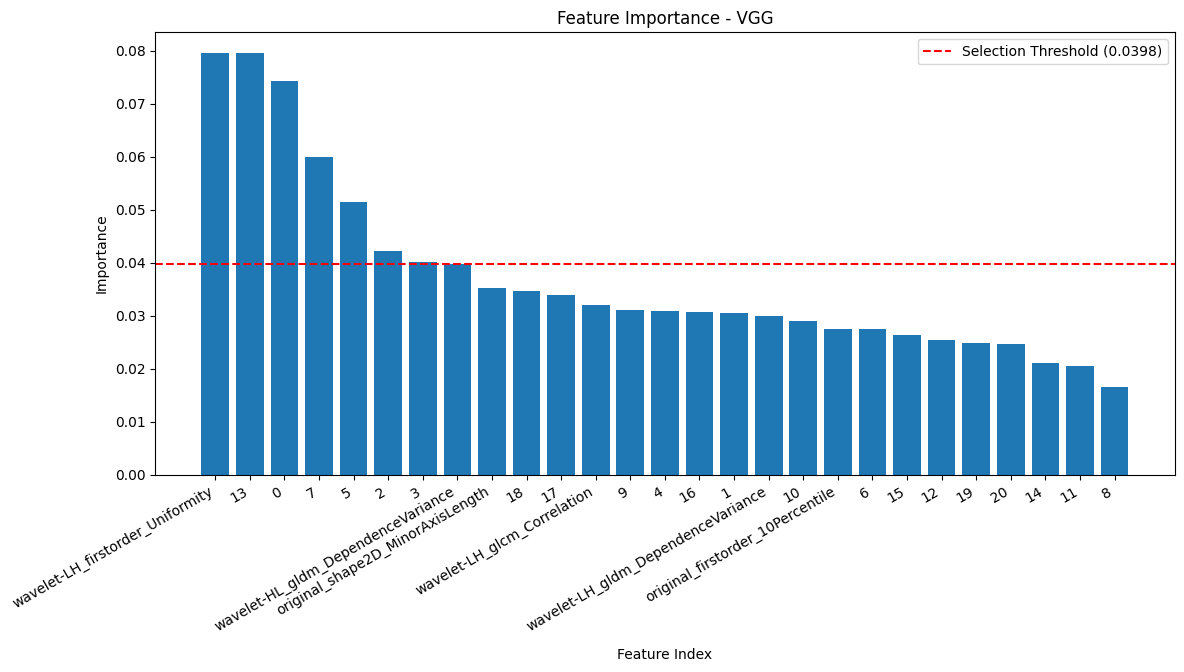

Classifier: RandomForest
Numero features: 8
Modalità: Max
F1 Score: 0.6452
ROC AUC: 0.8457
PR AUC: 0.7776
Accuracy: 0.7179
Balanced Accuracy: 0.7500
Best Threshold: 0.039768426802583655
Confusion Matrix (Test):
[[18  9]
 [ 2 10]]


In [63]:
import re

match = re.search(r'selected_features_combined_(.*?)_Rad.*?\.csv', file_path)
if(match.group(1) == 'INCRES'):
    nome_grafico = 'INCEPTION RESNET'
else:
    nome_grafico =match.group(1)


classifiers = ["SVM", "RandomForest", "MLP", "XgBoost", 'ensemble', 'Logistic']
modes = ['MV', 'Max', 'Mean']
best_classifier = None
best_results = None
best_mode = None

# Variabili per memorizzare il miglior punteggio
best_balanced_accuracy = -1
best_roc_auc = -1

# Loop su ciascun classificatore
for classifier in classifiers:
    for mode in modes:
        print(f"\n--- Risultati per {classifier} con mode {mode} (Validation) ---")
        
        # Risultati sul validation set
        results = classification_method_features_fixed(classifier, mode, x_train_expanded2, y_train_expanded2, features_val, y_val, patients_val)

        print(results['balanced_accuracy'])
        print(results['roc_auc'])

        # Verifica se questo classificatore ha la migliore balanced accuracy
        if results['balanced_accuracy'] > best_balanced_accuracy:
            best_balanced_accuracy = results['balanced_accuracy']
            best_roc_auc = results['roc_auc']  # Aggiorna anche ROC AUC
            best_classifier = classifier
            best_mode = mode
            best_results = results

        # In caso di parità sulla balanced accuracy, guarda la ROC AUC
        elif results['balanced_accuracy'] == best_balanced_accuracy and results['roc_auc'] > best_roc_auc:
            best_roc_auc = results['roc_auc']
            best_classifier = classifier
            best_mode = mode
            best_results = results

# Miglior classificatore trovato
print(f"\n--- Miglior classificatore: {best_classifier} con mode {best_mode} ---")
print(f"Balanced Accuracy: {best_results['balanced_accuracy']:.4f}")
print(f"ROC AUC: {best_results['roc_auc']:.4f}")
print(f"F1 Score: {best_results['f1']:.4f}")
print(f"Confusion Matrix (Validation):\n{best_results['confusion_matrix']}")

# Test con feature importance (RandomForest come default se il classificatore non ha feature importance)
print(f"\n--- Risultati per {best_classifier} (Test con feature importance) ---")
results_importance = classification_method_features_fixed_importance('RandomForest', best_classifier,best_mode, x_train_expanded1, y_train_expanded1, features_test, y_test, df, nome_grafico, patients_test)


# Stampa i risultati finali sul test set (con feature importance)
print(f"Classifier: {results_importance['classifier']}")
print(f"Numero features: {results_importance['number_features']}")
print(f"Modalità: {best_mode}")
print(f"F1 Score: {results_importance['f1']:.4f}")
print(f"ROC AUC: {results_importance['roc_auc']:.4f}")
print(f"PR AUC: {results_importance['pr_auc']:.4f}")
print(f"Accuracy: {results_importance['accuracy']:.4f}")
print(f"Balanced Accuracy: {results_importance['balanced_accuracy']:.4f}")
print(f"Best Threshold: {results_importance['best_threshold']}")
print(f"Confusion Matrix (Test):\n{results_importance['confusion_matrix']}")
